In [18]:
import numpy as np
from scipy.integrate import solve_ivp

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from model import PModel, ADModel
from dynamics import run_sim

#Global parameters for Pareto front
n_loci = 9
n_gens = 15
t = (0, 1000)
p1 = 0.2
p2 = 0.2
sigma1 = 0.2
sigma2 = 0.2
beta = 0.005
res_type = 'add'

In [19]:
cost = np.random.exponential(0.1, n_loci)
res = np.random.exponential(0.1, n_loci)

PF_sim = PModel(n_loci, res, cost, beta=beta, r_type=res_type)
PF_sim.normalize()
PF_sim.B = PF_sim.B * PF_sim.beta

X_t, I_t = run_sim(PF_sim, t, n_gens)

n_res_bins = 15
n_time_bins = 15

evol_plot = np.zeros((n_res_bins, n_time_bins))
res_bins = np.linspace(0, PF_sim.beta, n_res_bins)
time_bins = np.linspace(0, n_gens, n_time_bins)
time_vals = np.arange(0, n_gens)

for i in range(n_res_bins - 1):
    for j in range(n_time_bins - 1):
        evol_inds = np.logical_and(res_bins[i] < PF_sim.B,PF_sim.B <= res_bins[i+1])
        time_inds = np.logical_and(time_bins[j] < time_vals,time_vals <= time_bins[j+1])

        filter = np.outer(evol_inds, time_inds)

        if np.any(filter):
            evol_plot[i,j] = np.average(X_t[filter])

t_ticks = np.linspace(0, 1, 7)*n_time_bins
t_tick_labels = np.linspace(0, n_gens, 7, dtype=np.uint)

r_ticks = np.linspace(0, 1, 5)*n_res_bins
r_tick_labels = np.linspace(1, 0, 5)

In [20]:
def pareto_front(sim, n_steps=100):
	cost = np.zeros(n_steps)
	beta = np.linspace(0, np.max(sim.B), n_steps)

	for i, val in enumerate(beta):
		cost[i] = np.max((sim.F)[sim.B <= val])
		
	return (beta, cost)

front_res, front_costs = pareto_front(PF_sim)

In [21]:
coefs = np.polyfit(front_res, front_costs, 6)
birth_rates = np.poly1d(coefs)(front_res)

AD_sim = ADModel(res=front_res, b=birth_rates)
results = AD_sim.run_sim()

NameError: name 'solve_ivp' is not defined

/tmp/ipykernel_2263/4270655596.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ad_tick_labels)


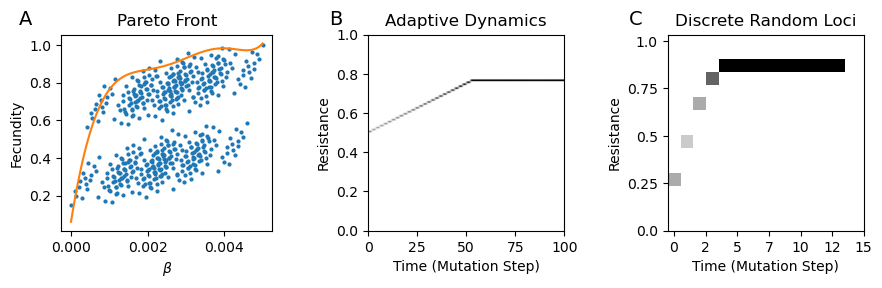

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))

coefs = np.polyfit(front_res, front_costs, 6)

ax[0].scatter(PF_sim.B, PF_sim.F, s=4)
#ax[0].plot(front_res, front_costs, color='tab:orange')
ax[0].plot(front_res, np.poly1d(coefs)(front_res), color='tab:orange')
ax[0].set_title('Pareto Front')
ax[0].set_ylabel('Fecundity')
ax[0].set_xlabel(r'$\beta$')

ad_ticks = np.linspace(0, 1, 5)*100
ad_tick_labels = np.linspace(0, 100, 5, dtype=np.uint)

ax[1].imshow(results[0], extent=[0,1,0,1], cmap='Greys')
ax[1].set_title('Adaptive Dynamics')
ax[1].set_ylabel('Resistance')
ax[1].set_xlabel('Time (Mutation Step)')
ax[1].set_xticklabels(ad_tick_labels)

genotypes = ax[2].imshow(np.log(1+evol_plot), cmap='Greys')
ax[2].set_title('Discrete Random Loci')
ax[2].set_ylabel('Resistance')
ax[2].set_xlabel('Time (Mutation Step)')
ax[2].set_xticks(t_ticks)
ax[2].set_yticks(r_ticks)
ax[2].set_xticklabels(t_tick_labels)
ax[2].set_yticklabels(r_tick_labels)

ax[0].annotate("A", xy=(-0.2, 1.05), xycoords="axes fraction", fontsize=14)
ax[1].annotate("B", xy=(-0.2, 1.05), xycoords="axes fraction", fontsize=14)
ax[2].annotate("C", xy=(-0.2, 1.05), xycoords="axes fraction", fontsize=14)

plt.tight_layout()